In [2]:
import tensorflow as tf
import os
import numpy as np
import tensorflow_io as tfio
import random
tf.random.set_seed(3407)
np.random.seed(3407)
random.seed(3407)

from helper_functions import (
    create_spectrogram_features,
    lite_model_from_file_predicts_dataset,
    get_file_size, 
    convert_bytes,
    evaluate_prediction,
)


from sklearn.metrics import confusion_matrix

In [3]:
sample_rate=16000

In [46]:
def create_spectrogram_features(audio, desired_length, sample_rate):
    # Make all audios the same length 
    # audio, _ = squeeze(audio)
    audio_length = tf.shape(audio)[0]
    if audio_length < desired_length:
        audio = tf.pad(audio, [[0, desired_length - audio_length]], mode='CONSTANT')
    else:
        audio = audio[:desired_length]

    #Create log Mel spectrogram
    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256,
                       fft_length=1024)
    spectrogram = tf.abs(stfts)

    # Warp the linear scale spectrogram into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
        upper_edge_hertz)
    mel_spectrogram = tf.tensordot(
    spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))
    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    # Get back color channel axis to make features accetable for the model input shape
    log_mel_spectrogram_with_color_channel = tf.expand_dims(log_mel_spectrogram, axis=-1).numpy()
    return log_mel_spectrogram_with_color_channel

In [47]:
# CNN model predicts all data from directory
directory = 'dataset/testing'

x_data = []
y_data = []
for root, dirs, files in os.walk(directory):
    for file in files:
        full_file_name = os.path.join(root, file)

        if "non_target" in str(full_file_name):
            class_encoded = 0
        elif "target" in str(full_file_name):
            class_encoded = 1

        audio, sr = tf.audio.decode_wav(tf.io.read_file(full_file_name))
        audio = tf.squeeze(audio, axis=-1)
        resampled_audio = tfio.audio.resample(audio, rate_in=48000, rate_out=sample_rate)
        # Prepare log mel spectrogram from audio
        spectrogram_feature = create_spectrogram_features(resampled_audio, desired_length=48000, sample_rate=sample_rate)

        # log_mel_spectrogram_with_color_channel = tf.expand_dims(spectrogram_feature, axis=-1).numpy()
        # spectrogram_with_batch = np.expand_dims(spectrogram_feature, axis=0)
        x_data.append(spectrogram_feature)
        y_data.append(class_encoded)
        break


In [48]:
len(x_data)

2

In [49]:
# Group1
group1_record_non_target_file1 = 'dataset/testing/non_target/1.000_0002_36wiH3sPukY_40.wav'
group1_record_non_target_file2 = 'dataset/testing/non_target/0.920_0001_703520.wav'
group1_record_non_target_file3 = 'dataset/testing/non_target/0.930_0012_305620.wav'

group1_record_target_file1 = 'dataset/testing/target/0.770_0001_200624_1661_2.wav'
group1_record_target_file2 = 'dataset/testing/target/0.940_0041_736736.wav'
group1_record_target_file3 = 'dataset/testing/target/0.960_0052_86290.wav'


In [50]:
import matplotlib.pyplot as plt

In [51]:
sample_rate

16000

dataset/testing/non_target/1.000_0002_36wiH3sPukY_40.wav
(184, 80)
80
14720
dataset/testing/non_target/0.920_0001_703520.wav
(184, 80)
80
14720
dataset/testing/non_target/0.930_0012_305620.wav
(184, 80)
80
14720
dataset/testing/target/0.770_0001_200624_1661_2.wav
(184, 80)
80
14720
dataset/testing/target/0.940_0041_736736.wav
(184, 80)
80
14720
dataset/testing/target/0.960_0052_86290.wav
(184, 80)
80
14720


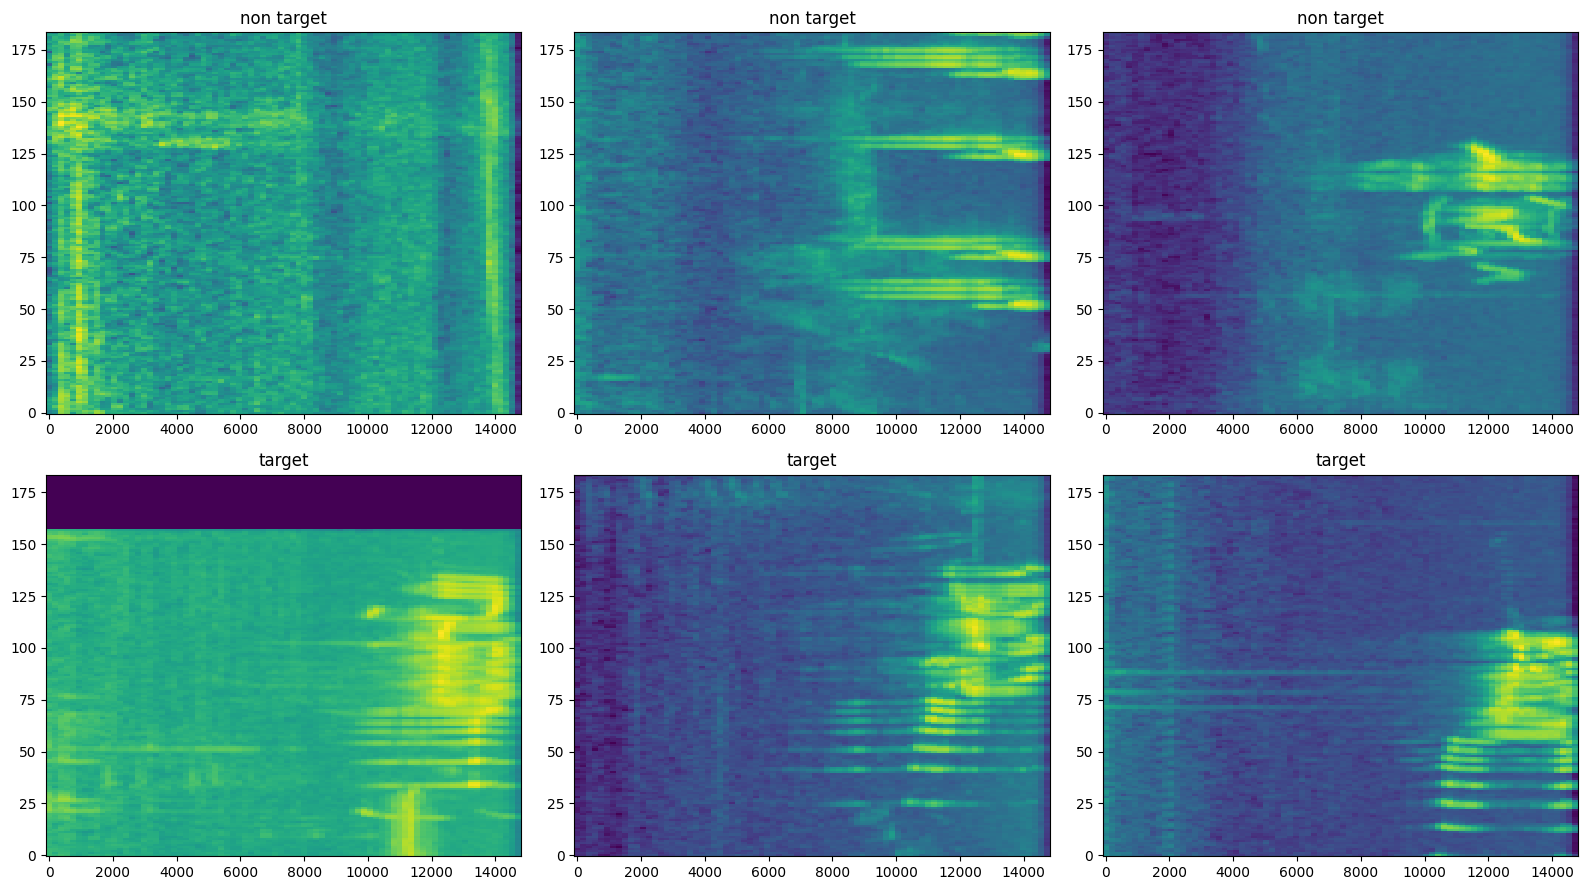

In [99]:
def squeeze(audio, labels=None):
    """
    This dataset only contains single channel audio, so use
    the tf.squeeze function to drop the extra axis
    """
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

def plot_spectrogram(spectrogram, ax):
    height = spectrogram.shape[0]
    width = spectrogram.shape[1]
    print(width)
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    print(np.size(spectrogram))
    # t = np.linspace(0, 3, 48000, endpoint=False)
    # X = range(width)
    Y = range(height)
    # Y=np.linspace(0, 3, 48000, dtype=int)
    ax.pcolormesh(X, Y, spectrogram)

data_points_to_plot = [
                        (group1_record_non_target_file1, "non target"),
                        (group1_record_non_target_file2, "non target"),
                        (group1_record_non_target_file3, "non target"),
                        (group1_record_target_file1, "target"),
                        (group1_record_target_file2, "target"),
                        (group1_record_target_file3, "target")
                        ]
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for indx, record_data in enumerate(data_points_to_plot):
    r = indx // cols
    c = indx % cols
    ax = axes[r][c]
    print(record_data[0])
    signal, sr = tf.audio.decode_wav(tf.io.read_file(record_data[0]))
    signal, _ = squeeze(signal)
    resampled_audio = tfio.audio.resample(signal, rate_in=48000, rate_out=sample_rate)
    log_mel_spectrogram = create_spectrogram_features(resampled_audio, desired_length=48000, sample_rate=sample_rate)
    log_mel_spectrogram_without_color_channel, _ = squeeze(log_mel_spectrogram)
    print(log_mel_spectrogram_without_color_channel.shape)
    plot_spectrogram(log_mel_spectrogram_without_color_channel, ax)
    ax.set_title(record_data[1])

plt.tight_layout() 
plt.show()

In [69]:
desired_length =48000

dataset/testing/non_target/1.000_0002_36wiH3sPukY_40.wav
(184, 80)
dataset/testing/non_target/0.920_0001_703520.wav
(184, 80)
dataset/testing/non_target/0.930_0012_305620.wav
(184, 80)
dataset/testing/target/0.770_0001_200624_1661_2.wav
(500, 80)
dataset/testing/target/0.940_0041_736736.wav
(184, 80)
dataset/testing/target/0.960_0052_86290.wav
(184, 80)


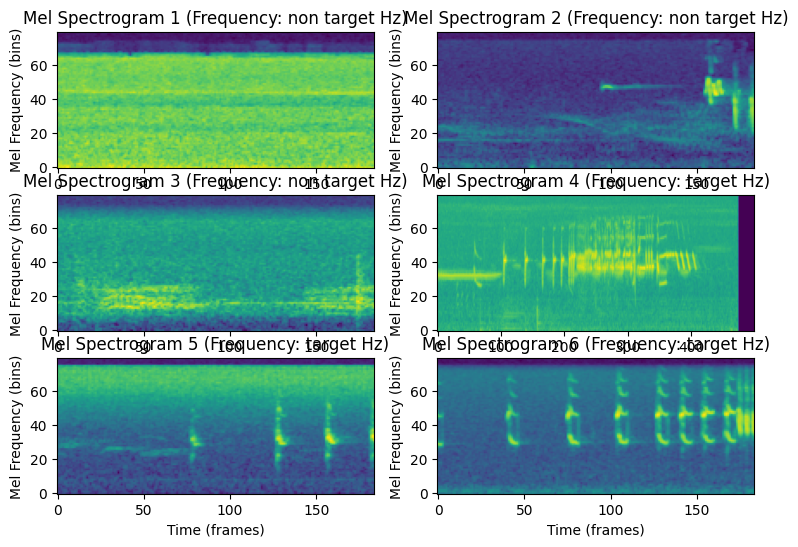

In [86]:
def read_file_and_compute_mel_spectr(file_name):
    audio, sr = tf.audio.decode_wav(tf.io.read_file(file_name))
    audio = tf.squeeze(audio, axis=-1)
    resampled_audio = tfio.audio.resample(audio, rate_in=48000, rate_out=sample_rate)

    # Prepare log mel spectrogram from audio
    audio_length = tf.shape(resampled_audio)[0]
    if audio_length < desired_length:
        audio = tf.pad(audio, [[0, desired_length - audio_length]], mode='CONSTANT')
    else:
        audio = audio[:desired_length]
    #Create log Mel spectrogram
    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256,
                        fft_length=1024)
    spectrogram = tf.abs(stfts)
    # Warp the linear scale spectrogram into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
        upper_edge_hertz)
    mel_spectrogram = tf.tensordot(
    spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

    mel_spectrogram = mel_spectrogram.numpy()
    return mel_spectrogram

    
data_points_to_plot = [
                        (group1_record_non_target_file1, "non target"),
                        (group1_record_non_target_file2, "non target"),
                        (group1_record_non_target_file3, "non target"),
                        (group1_record_target_file1, "target"),
                        (group1_record_target_file2, "target"),
                        (group1_record_target_file3, "target")
                        ]

fig, axes = plt.subplots(3, 2, figsize=(9, 6))
axes = axes.flatten()

for i, data_point in enumerate(data_points_to_plot):
    print(data_point[0])
    mel_spectr = read_file_and_compute_mel_spectr(data_point[0])
    print(mel_spectr.shape)
    ax = axes[i]
    ax.imshow(np.log(mel_spectr.T + 1e-6), aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Mel Spectrogram {i + 1} (Frequency: {data_point[1]} Hz)')
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Mel Frequency (bins)')


In [91]:
# Group2
group2_record_non_target_file1 = 'dataset/testing/non_target/1.000_0002_-uBbPbRML3U_290.wav'
group2_record_non_target_file2 = 'dataset/testing/non_target/0.940_0030_112804.wav'
group2_record_non_target_file3 = 'dataset/testing/non_target/0.930_0011_121693.wav'

group2_record_target_file1 = 'dataset/testing/target/0.970_0058_R21_2022_02_23_07_59_47.wav'
group2_record_target_file2 = 'dataset/testing/target/0.940_0009_784426.wav'
group2_record_target_file3 = 'dataset/testing/target/0.930_0024_420362.wav'

dataset/testing/non_target/1.000_0002_-uBbPbRML3U_290.wav
(184, 80)
dataset/testing/non_target/0.940_0030_112804.wav
(184, 80)
dataset/testing/non_target/0.930_0011_121693.wav
(184, 80)
dataset/testing/target/0.970_0058_R21_2022_02_23_07_59_47.wav
(184, 80)
dataset/testing/target/0.940_0009_784426.wav
(184, 80)
dataset/testing/target/0.930_0024_420362.wav
(184, 80)


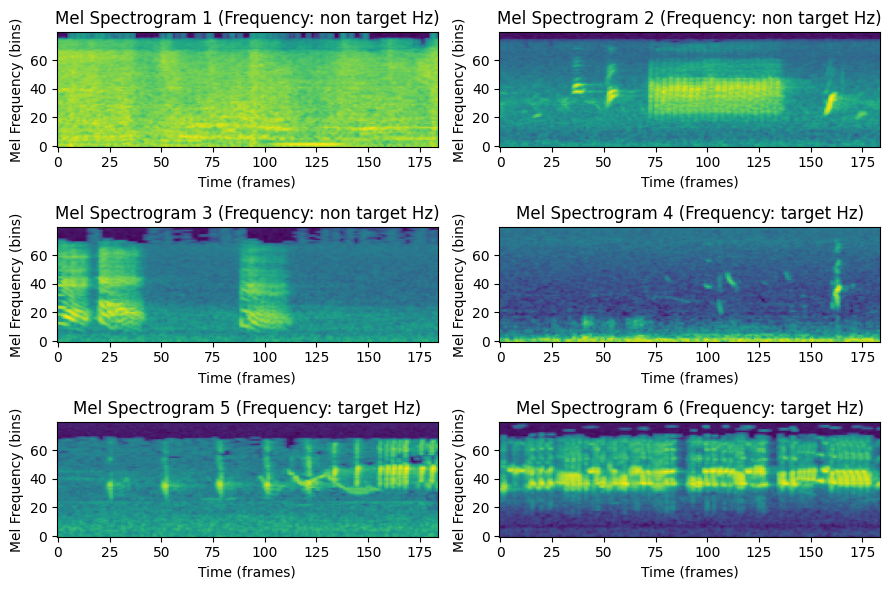

In [98]:
data_points_to_plot = [
                        (group2_record_non_target_file1, "non target"),
                        (group2_record_non_target_file2, "non target"),
                        (group2_record_non_target_file3, "non target"),
                        (group2_record_target_file1, "target"),
                        (group2_record_target_file2, "target"),
                        (group2_record_target_file3, "target")
                        ]

fig, axes = plt.subplots(3, 2, figsize=(9, 6))
axes = axes.flatten()

for i, data_point in enumerate(data_points_to_plot):
    print(data_point[0])
    mel_spectr = read_file_and_compute_mel_spectr(data_point[0])
    print(mel_spectr.shape)
    ax = axes[i]
    ax.imshow(np.log(mel_spectr.T + 1e-6), aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Mel Spectrogram {i + 1} (Frequency: {data_point[1]} Hz)')
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Mel Frequency (bins)')

plt.tight_layout() 
plt.show()

dataset/testing/non_target/0.920_0001_703520.wav
(184, 80)
dataset/testing/non_target/0.930_0012_305620.wav
(184, 80)
dataset/testing/target/0.960_0052_86290.wav
(184, 80)
dataset/testing/target/0.930_0024_420362.wav
(184, 80)


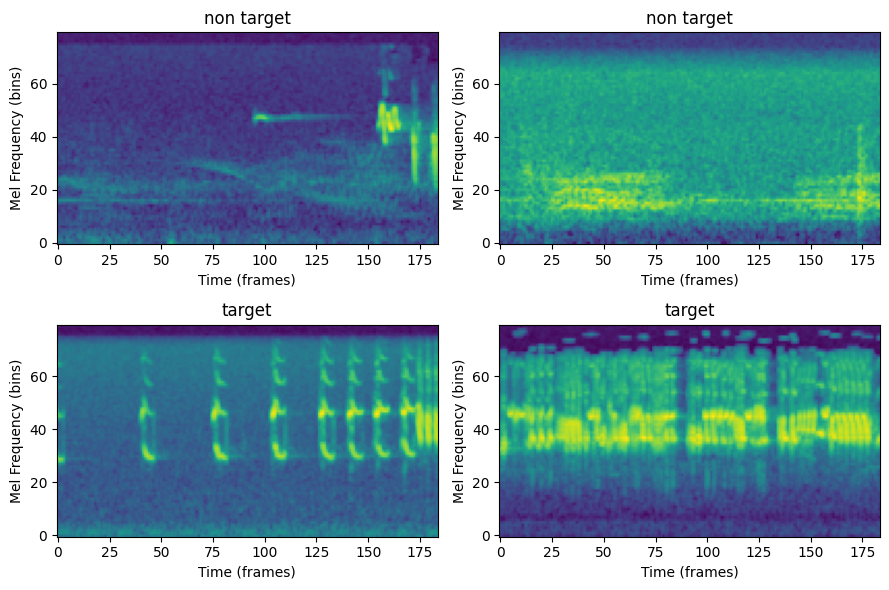

In [100]:
def read_file_and_compute_mel_spectr(file_name):
    audio, sr = tf.audio.decode_wav(tf.io.read_file(file_name))
    audio = tf.squeeze(audio, axis=-1)
    resampled_audio = tfio.audio.resample(audio, rate_in=48000, rate_out=sample_rate)

    # Prepare log mel spectrogram from audio
    audio_length = tf.shape(resampled_audio)[0]
    if audio_length < desired_length:
        audio = tf.pad(audio, [[0, desired_length - audio_length]], mode='CONSTANT')
    else:
        audio = audio[:desired_length]
    #Create log Mel spectrogram
    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256,
                        fft_length=1024)
    spectrogram = tf.abs(stfts)
    # Warp the linear scale spectrogram into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
        upper_edge_hertz)
    mel_spectrogram = tf.tensordot(
    spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

    mel_spectrogram = mel_spectrogram.numpy()
    return mel_spectrogram

    
data_points_to_plot = [
                        (group1_record_non_target_file2, "non target"),
                        (group1_record_non_target_file3, "non target"),
                        (group1_record_target_file3, "target"),
                        (group2_record_target_file3, "target"),
                        ]

fig, axes = plt.subplots(2, 2, figsize=(9, 6))
axes = axes.flatten()

for i, data_point in enumerate(data_points_to_plot):
    print(data_point[0])
    mel_spectr = read_file_and_compute_mel_spectr(data_point[0])
    print(mel_spectr.shape)
    ax = axes[i]
    ax.imshow(np.log(mel_spectr.T + 1e-6), aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'{data_point[1]}')
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Mel Frequency (bins)')

plt.tight_layout() 
plt.show()